## Pipeline

#### The pipeline I have tried to implement is:
<p> Step 1 - Load, Preprocess and Collect the Audio Embeddings from a pretrained VGGish model </p>
<p> Step 2 - Create a simple ANN classifier that learns to classify the extracted Audio                        Embeddings to the appropriate person. (Training data is labelled, so use Supervised              Learning).
</p>
<p> Step 3 - Now, for the Test dataset, first Load, Preprocess and extract the Audio Embeddings                similarly as before using VGGish model. </p>
<p> Step 4 - Now, pass the audio embeddings of Test data into the already trained ANN                          classifier till the penultimate layer and collect the extracted audio features. It                is expected that these extracted audio features contain fine low-level information                that will aid in recognising the speaker. </p>
<p> Step 5 - Since the Test Data is unlabelled, so we must apply Unsupervised Learning. Here, I                have used a K-Means Clustering to split the test  audio files into categories based              on their similarity wrt the extracted audio features from the trained ANN. </p>
    

## Imports

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

import os
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras import Model

## Load the VGGish model.

The VGGish model is a neural network architecture based on the VGG family of image classification networks, developed by Google and is specifically designed for audio classification tasks, in the context of audio embeddings. 

In [2]:
vggish_model = hub.load('https://kaggle.com/models/google/vggish/frameworks/TensorFlow2/variations/vggish/versions/1')

## Preprocess Audio Clips

The load_and_preprocess_audio function first loads the audio file using Librosa Library, and then resamples it (if required) to the target sample rate of 44.1 kHz. The sampling rate determines how many data points or "samples" are taken per second to represent the continuous analog audio signal in a digital form. Higher sampling rates can capture more details in the audio signal, especially at higher frequencies, but they also require more storage space and processing power. Lower sampling rates may result in information loss, particularly for high-frequency components.

It should be noted that all audio files were not of the same duration in the given dataset, hence their respective embeddings would differ in terms of the shapes of their NumPy arrays, making them unfit to be fed into a neural network for training purposes. So, shorter audio files (less than 10 seconds) are padded with zero, whereas audio files longer than 0 are cropped till 10 seconds. (By manual inspection, I did not find any audio clip longer than 10 seconds duration, so the probability of information loss can be ignored).

After that, the audio arrays are fed to the VGGish model to obtain the audio embeddings. We also check if the embeddings are of the shape [None, 128]

In [3]:
def load_and_preprocess_audio(file_path, target_duration=10, target_sr=44100):
    # Load audio file with original sampling rate
    audio, sr = librosa.load(file_path, sr=None)
    
    # Resample if needed
    if sr != target_sr:
        audio = librosa.resample(y=audio, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    
    # Ensure target duration
    target_length = int(sr * target_duration)
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))
    elif len(audio) > target_length:
        audio = audio[:target_length]
    
    
    # Run the model, check the output.
    embeddings = vggish_model(audio)
    embeddings.shape.assert_is_compatible_with([None, 128])
    return embeddings

## Training Data

Store the file paths of the audio files under each class in a list and shuffles that list.

In [4]:
file_paths = []

for root, dirs, files in os.walk("C:/Users/nidul/Desktop/ACCA Folder My/Signal processing cup/ROBOVOX_SP_CUP_2024/single-channel/enrollment"):
    if files!=[]:
        for file in files:
            audio_path = root + "/" + file
            file_paths.append(audio_path)
random.shuffle(file_paths)
print(file_paths)

['C:/Users/nidul/Desktop/ACCA Folder My/Signal processing cup/ROBOVOX_SP_CUP_2024/single-channel/enrollment\\spk_56/spk_56-56_52_0_1_d6_ch5.wav', 'C:/Users/nidul/Desktop/ACCA Folder My/Signal processing cup/ROBOVOX_SP_CUP_2024/single-channel/enrollment\\spk_33/spk_33-33_38_1_0_d4_ch5.wav', 'C:/Users/nidul/Desktop/ACCA Folder My/Signal processing cup/ROBOVOX_SP_CUP_2024/single-channel/enrollment\\spk_31/spk_31-31_10_0_0_d4_ch5.wav', 'C:/Users/nidul/Desktop/ACCA Folder My/Signal processing cup/ROBOVOX_SP_CUP_2024/single-channel/enrollment\\spk_62/spk_62-62_10_0_0_d6_ch5.wav', 'C:/Users/nidul/Desktop/ACCA Folder My/Signal processing cup/ROBOVOX_SP_CUP_2024/single-channel/enrollment\\spk_41/spk_41-41_22_0_0_d2_ch5.wav', 'C:/Users/nidul/Desktop/ACCA Folder My/Signal processing cup/ROBOVOX_SP_CUP_2024/single-channel/enrollment\\spk_2/spk_2-2_1_1_0_d6_ch5.wav', 'C:/Users/nidul/Desktop/ACCA Folder My/Signal processing cup/ROBOVOX_SP_CUP_2024/single-channel/enrollment\\spk_74/spk_74-74_11_0_0_d

Obtain the preprocessed VGGish embeddings of each audio file and store them under X_train, and store class ground truths under y_train.

In [14]:
X_train = []
y_train = [] 
labels = []


for file in file_paths:
    embedding = load_and_preprocess_audio(file)
    X_train.append(embedding)
    label = ""
    for char in list(file.split('/'))[-1].split('-')[0].split('_')[1]:
        if char!="-":
            label+=char
        else:
            break
    temp = np.zeros(201)
    temp[int(label)] = 1
    y_train.append(temp)
    labels.append(int(label))
# print(X_train)
# print(y_train)
print(len(labels))

225


Convert the lists into numpy arrays.

In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)
labels = np.array(labels)

In [16]:
print(X_train.shape)
print(y_train.shape)
print(labels.shape)

(225, 28, 128)
(225, 201)
(225,)


## Building the Classifier

In [17]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

Converting all of them into tensors.

In [18]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(202, 28, 128)
(202, 201)
(23, 28, 128)
(23, 201)


Defining the callbacks.

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

# Define callback functions
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5', monitor='val_accuracy', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='./logs')
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

#### Creating an Artificial Neural Network that learns to classify the audio embeddings into appropriate classes (out of given 201 persons).

In [22]:
num_classes = 201

# Define the L2 regularization parameter
l2_regularization = 1e-6

# Define the dropout rate
dropout_rate = 0.2

model = models.Sequential([
    layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    
    layers.Dense(3200, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    #layers.Dropout(dropout_rate),
    
    layers.Dense(2400, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    #layers.Dropout(dropout_rate),
    
    layers.Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    #layers.Dropout(dropout_rate),

    # Output layer with softmax activation
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=optimizers.Adam(lr = 0.0001),
              loss='categorical_crossentropy',  # Use 'categorical_crossentropy' if using one-hot encoded labels
              metrics=['accuracy'])

# Train the model with callbacks
model.fit(X_train, y_train, 
          batch_size=64, 
          epochs=100, 
          validation_data=(X_val, y_val), 
          callbacks=[checkpoint_callback, 
                     early_stopping_callback, 
                     tensorboard_callback,
                     reduce_lr_callback])

Epoch 1/100
4/4 [==============================] - 1s 223ms/step - loss: 5.2728 - accuracy: 0.0198 - val_loss: 5.3246 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
4/4 [==============================] - 0s 36ms/step - loss: 4.5922 - accuracy: 0.1535 - val_loss: 5.3377 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/100
4/4 [==============================] - 0s 29ms/step - loss: 4.1146 - accuracy: 0.1931 - val_loss: 5.4718 - val_accuracy: 0.0435 - lr: 1.0000e-04
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 3.6928 - accuracy: 0.2673 - val_loss: 5.5606 - val_accuracy: 0.0435 - lr: 1.0000e-04
Epoch 5/100
4/4 [==============================] - 0s 24ms/step - loss: 3.3036 - accuracy: 0.2970 - val_loss: 5.6524 - val_accuracy: 0.0435 - lr: 1.0000e-04
Epoch 6/100
4/4 [==============================] - 0s 24ms/step - loss: 2.9234 - accuracy: 0.3812 - val_loss: 5.6725 - val_accuracy: 0.0435 - lr: 1.0000e-04
Epoch 7/100
4/4 [==============================] 

## KMeans Clustering 

### (Checking if a KMeans can cluster the Train data accurately be=ased on given labels)

In [24]:
X_train = []
y_train = [] 


for file in file_paths:
    embedding = load_and_preprocess_audio(file)
    X_train.append(embedding)
    label = ""
    for char in list(file.split('/'))[-1].split('-')[0].split('_')[1]:
        if char!="-":
            label+=char
        else:
            break
    temp = np.zeros(201)
    temp[int(label)] = 1
    y_train.append(temp)

In [25]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [26]:
print(X_train.shape)
print(y_train.shape)

(225, 28, 128)
(225, 201)


In [27]:
penultimate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
penultimate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1_input (InputLayer  [(None, 28, 128)]        0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 3584)              0         
                                                                 
 dense_4 (Dense)             (None, 3200)              11472000  
                                                                 
 dense_5 (Dense)             (None, 2400)              7682400   
                                                                 
 dense_6 (Dense)             (None, 1000)              2401000   
                                                                 
Total params: 21,555,400
Trainable params: 21,555,400
Non-trainable params: 0
_________________________________________________

In [44]:
penultimate_layer_output = penultimate_layer_model.predict(X_train)

1/8 [==>...........................] - ETA: 0s

8/8 [==============================] - 0s 8ms/step


In [45]:
penultimate_layer_output.shape

(225, 1000)

In [46]:
import numpy as np
from sklearn.cluster import KMeans

# Apply k-means clustering
num_clusters = 200 # Adjust the number of clusters based on your requirements
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(penultimate_layer_output)

c:\Users\nidul\.conda\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [47]:
cluster_labels.shape

(225,)

#### Predicting the accuracy of the clusters

In [48]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# Assuming labels contains the true labels and cluster_labels contains the cluster labels from K-means
# y_train and kmeans_labels should have the same length

# Find the most common true label within each cluster
cluster_to_label = {}
for cluster in np.unique(cluster_labels):
    mask = (cluster_labels == cluster)
    most_common_label = mode(y_train[mask]).mode[0]
    cluster_to_label[cluster] = most_common_label

# Map cluster labels to true labels
predicted_labels = np.array([cluster_to_label[cluster] for cluster in cluster_labels])

# Compute accuracy
accuracy = accuracy_score(y_train, predicted_labels)

print("Accuracy:", accuracy)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

## Validation Data

In [49]:
penultimate_layer_output = penultimate_layer_model.predict(X_val)
penultimate_layer_output.shape

1/1 [==============================] - 0s 19ms/step


(23, 1000)

In [51]:
import numpy as np
from sklearn.cluster import KMeans

# Apply k-means clustering
num_clusters = 100  # Adjust the number of clusters based on your requirements
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(penultimate_layer_output)

ValueError: n_samples=23 should be >= n_clusters=100.

In [52]:
cluster_labels.shape

(225,)

In [53]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# Assuming labels contains the true labels and cluster_labels contains the cluster labels from K-means
# y_train and kmeans_labels should have the same length

# Find the most common true label within each cluster
cluster_to_label = {}
for cluster in np.unique(cluster_labels):
    mask = (cluster_labels == cluster)
    most_common_label = mode(y_val[mask]).mode[0]
    cluster_to_label[cluster] = most_common_label

# Map cluster labels to true labels
predicted_labels = np.array([cluster_to_label[cluster] for cluster in cluster_labels])

# Compute accuracy
accuracy = accuracy_score(y_val, predicted_labels)

print("Accuracy:", accuracy)

ValueError: Shapes (23,) and (225,) are incompatible

In [54]:
import matplotlib.pyplot as plt

# Try different values of k
k_values = range(1, 146, 20)  # Adjust the range based on your requirements

# Fit k-means for each k and calculate inertia
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(penultimate_layer_output)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

c:\Users\nidul\.conda\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nidul\.conda\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: n_samples=23 should be >= n_clusters=41.

Though the Elbow Curve suggests that the optimal no. of clusters should be around 20 but it is found that for the Validation Data, for 100 clusters, the classification performance is more accurate.

## Testing Data

Storing the file paths for Test Data

In [203]:
file_paths = {}

for root, dirs, files in os.walk("/kaggle/input/person-identification-using-speech-recognition/testing_split"):
    if files!=[]:
        for file in files:
            audio_path = root + "/" + file
            key = int(file[:-4])
            file_paths[key] = audio_path

In [204]:
file_paths

{611: '/kaggle/input/person-identification-using-speech-recognition/testing_split/611.wav',
 364: '/kaggle/input/person-identification-using-speech-recognition/testing_split/364.wav',
 116: '/kaggle/input/person-identification-using-speech-recognition/testing_split/116.wav',
 374: '/kaggle/input/person-identification-using-speech-recognition/testing_split/374.wav',
 456: '/kaggle/input/person-identification-using-speech-recognition/testing_split/456.wav',
 626: '/kaggle/input/person-identification-using-speech-recognition/testing_split/626.wav',
 296: '/kaggle/input/person-identification-using-speech-recognition/testing_split/296.wav',
 66: '/kaggle/input/person-identification-using-speech-recognition/testing_split/66.wav',
 468: '/kaggle/input/person-identification-using-speech-recognition/testing_split/468.wav',
 526: '/kaggle/input/person-identification-using-speech-recognition/testing_split/526.wav',
 339: '/kaggle/input/person-identification-using-speech-recognition/testing_split/

In [205]:
import pandas as pd

file_path = '/kaggle/input/person-identification-using-speech-recognition/Sample_submission - test_mapping.csv'
df = pd.read_csv(file_path)
print(df.head())

   File_name Person_id
0        438        AA
1        146        AA
2         79        AA
3        117        AA
4        806        AA


In [206]:
Submission_Files = df['File_name']

In [207]:
Submission_Files

0      438
1      146
2       79
3      117
4      806
      ... 
632    897
633    162
634    668
635    795
636    660
Name: File_name, Length: 637, dtype: int64

#### Preprocess and Capture VGGish embeddings for the Test Audio Files

In [208]:
X_test = []

for val in Submission_Files:
    file = file_paths[val]
    embedding = load_and_preprocess_audio(file)
    X_test.append(embedding)

In [209]:
X_test = np.array(X_test)
X_test.shape

(637, 28, 128)

In [210]:
penultimate_layer_output = penultimate_layer_model.predict(X_test)
penultimate_layer_output.shape

20/20 [==============================] - 0s 1ms/step


(637, 1000)

#### Plot the Elbow Curve to find the optimal no of clusters 

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

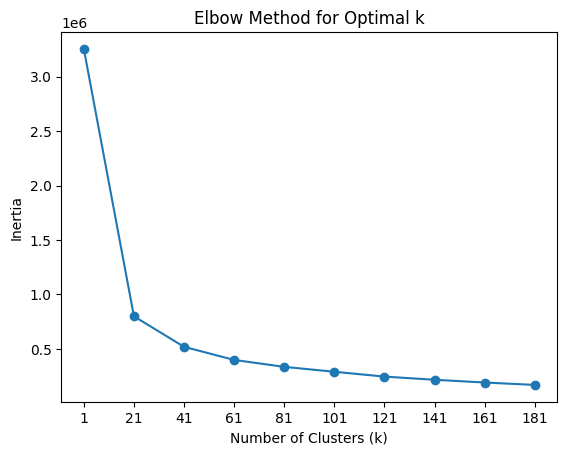

In [211]:
import matplotlib.pyplot as plt

# Try different values of k
k_values = range(1, 200, 20)  # Adjust the range based on your requirements

# Fit k-means for each k and calculate inertia
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(penultimate_layer_output)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
# Ensure all x-values are visible
plt.xticks(k_values)
plt.show()

It is found that the optimal no of clusters is nearabout 20. So, it is better to plot the Elbow Curve once again in the K-values range of 1-50.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

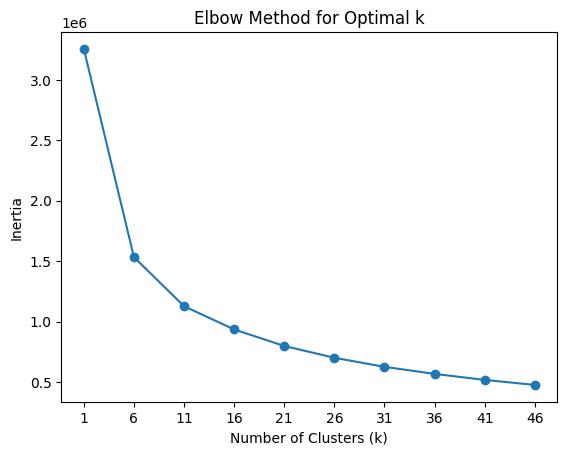

In [212]:
import matplotlib.pyplot as plt

# Try different values of k
k_values = range(1, 50, 5)  # Adjust the range based on your requirements

# Fit k-means for each k and calculate inertia
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(penultimate_layer_output)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
# Ensure all x-values are visible
plt.xticks(k_values)
plt.show()

Here, we find that the curve elbows at k = 11. But after manual trial and errors, I found that for 100 clusters, the scores are highest!

In [213]:
import numpy as np
from sklearn.cluster import KMeans

# Apply k-means clustering
num_clusters = 100  # Adjust the number of clusters based on your requirements
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(penultimate_layer_output)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [214]:
cluster_labels.shape

(637,)

In [215]:
cluster_labels

array([35, 36, 36, 36, 36, 22, 96, 20, 96, 96, 86, 86, 77, 92, 35, 36, 22,
       63, 77, 92, 65, 20, 20, 20, 20, 20, 67, 39, 88,  1, 67, 67, 67, 65,
       65, 32, 86, 86, 86, 42, 42, 96, 96,  8, 96,  8,  2, 35, 35, 39,  2,
       97,  2, 35,  1, 77, 67, 77, 30, 43, 88, 73, 73,  5, 58,  5, 58, 78,
        5, 43, 57, 43,  5, 89, 89, 51, 89, 51, 53, 64, 74, 74, 74, 74, 74,
       98, 52, 41, 22, 43, 22, 44, 25, 36, 25, 42, 96, 42, 96, 22, 22, 78,
        5,  5,  5,  5, 57, 19, 19, 19, 19, 19, 19, 61, 59, 59, 28, 10, 18,
       87, 18, 18, 18, 18, 18, 18, 66,  9,  9,  9,  9,  9, 66, 30, 30, 59,
       59, 56, 56,  1, 56, 56, 85,  6,  6, 85,  6,  6, 85, 57, 43, 43, 43,
       43,  7,  7, 43, 43, 28, 29, 54, 75, 59, 59, 59, 10, 32, 32, 65, 92,
       92, 32, 32, 65, 92, 92, 28, 29, 54, 75, 50, 50, 50, 50, 64, 64, 52,
       72, 72, 72, 72, 72, 72, 73, 17, 40, 60, 13,  3,  3, 73, 73, 25, 25,
       25,  9,  9,  9, 66,  9,  9,  9, 45, 45, 45, 21, 64,  0, 25,  2,  2,
       25, 25, 25, 25, 14

In [216]:
df['Person_id'] = cluster_labels

In [217]:
#!rm '/kaggle/working/submission3.csv'

In [218]:
df.to_csv('Final_Submission.csv', index=False)